In [1]:
print('kernel_on')

kernel_on


# Exploratory Analysis on DialogRE:
- **Objective**: Analyze dialogue relations data from JSON files & estimate data synthesization costs
- **Process**: Convert data to DataFrame, flatten Relations column, and extract `relation_type`
- **Analysis**: Study distribution of `relation_type`, with a special focus on excluding `no_relation`

In [12]:
from src.paths import LOCAL_PROCESSED_DATA_PATH
from src.statistics import get_counts_and_percentages

from pathlib import Path
import pandas as pd
import json
import glob
import math

# Get a list of all json files in the directory, excluding 'dev'
files = [Path(f) for f in glob.glob(str(LOCAL_PROCESSED_DATA_PATH / "dialog-re-fixed-relations/*.json"))]
files = [Path(f) for f in glob.glob(str(LOCAL_PROCESSED_DATA_PATH / "dialog-re-ternary/*.json"))]


# Create an empty DataFrame
df1 = pd.DataFrame(columns=["Dialogue", "Relations", "Origin"])

# Loop over all json files in the directory
for file_name in files:
    with open(file_name, 'r') as file:
        data = json.load(file)

        # Convert the data to a DataFrame
        df_temp = pd.DataFrame(data, columns=["Dialogue", "Relations"])

        # Add a new column to this DataFrame for the origin
        df_temp["Origin"] = file_name.stem  # This will get just the file name without the extension

        # Append the temporary DataFrame to the main DataFrame
        df1 = pd.concat([df1, df_temp], ignore_index=True)
df1

,Dialogue,Relations,Origin
0,"[Speaker 1: Hey!, Speaker 2: Hey., Speaker 3: ...","[{'y': 'casting director', 'x': 'Ann', 'rid': ...",dev
1,"[Speaker 1, Speaker 2: Hi, Speaker 3: Hi! Hey ...","[{'y': 'Speaker 2', 'x': 'Speaker 1', 'rid': [...",dev
2,"[Speaker 1, Speaker 2: Hi!, Speaker 3: Hey!, S...","[{'y': 'man', 'x': 'Speaker 4', 'rid': [1], 'r...",dev
3,[Speaker 1: Wow! It looks like we got a lot of...,"[{'y': 'baby', 'x': 'Speaker 2', 'rid': [1], '...",dev
4,"[Speaker 1: Now, Mom, everything's going fine,...","[{'y': '26', 'x': 'Speaker 1', 'rid': [2], 'r'...",dev
...,...,...,...
1783,"[Speaker 1: Nice camoflauge man, for a minute ...","[{'y': 'Speaker 1', 'x': 'Speaker 2', 'rid': [...",train
1784,"[Speaker 1: Well, I'm sure you'll teach her a ...","[{'y': 'Sir', 'x': 'Speaker 1', 'rid': [1], 'r...",train
1785,[Speaker 1: You know what? I can't even worry ...,"[{'y': 'baby', 'x': 'Speaker 1', 'rid': [1], '...",train
1786,"[Speaker 1: And cut. Hey, Butt Guy, what the h...","[{'y': 'Butt Guy', 'x': 'Speaker 2', 'rid': [2...",train


In [13]:
get_counts_and_percentages(df1, ['Origin'])

,Counts,%
Origin,,
train,1073,60.0
dev,358,20.0
test,357,20.0


In [14]:
# flatten Relations column
relations = df1['Relations'].apply(pd.Series).stack().reset_index(drop=True)

# create new dataframe
df2 = pd.DataFrame({'Relations': relations})

# extract 'relation_type' from dictionary and add it as a new column in df2
df2['relation_type'] = df2['Relations'].apply(lambda x: x['r'][0])

# drop the 'Relations' column
df2 = df2.drop('Relations', axis=1)

# Now, we can count the amount of each 'relation_type'
relation_stats = get_counts_and_percentages(df2, ['relation_type'])

relation_stats

,Counts,%
relation_type,,
no_relation,16489,62.8
with_relation,7650,29.2
unanswerable,2099,8.0


In [15]:
mask = df2.relation_type != 'no_relation'
relation_stats_original = get_counts_and_percentages(df2[mask], ['relation_type'])
relation_stats_original
relation_stats_original

,Counts,%
relation_type,,
with_relation,7650,78.5
unanswerable,2099,21.5


In [7]:
df1['char_count'] = df1.apply(lambda x: len(f"{x.Dialogue},{x.Relations}"), axis=1)

df1

,Dialogue,Relations,Origin,char_count
0,"[Speaker 1: Hey!, Speaker 2: Hey., Speaker 3: ...","[{'y': 'casting director', 'x': 'Ann', 'rid': ...",dev,9235
1,"[Speaker 1, Speaker 2: Hi, Speaker 3: Hi! Hey ...","[{'y': 'Speaker 2', 'x': 'Speaker 1', 'rid': [...",dev,2195
2,"[Speaker 1, Speaker 2: Hi!, Speaker 3: Hey!, S...","[{'y': 'man', 'x': 'Speaker 4', 'rid': [37], '...",dev,8808
3,[Speaker 1: Wow! It looks like we got a lot of...,"[{'y': 'baby', 'x': 'Speaker 2', 'rid': [37], ...",dev,1959
4,"[Speaker 1: Now, Mom, everything's going fine,...","[{'y': '26', 'x': 'Speaker 1', 'rid': [25], 'r...",dev,964
...,...,...,...,...
1783,"[Speaker 1: Nice camoflauge man, for a minute ...","[{'y': 'Speaker 1', 'x': 'Speaker 2', 'rid': [...",train,2660
1784,"[Speaker 1: Well, I'm sure you'll teach her a ...","[{'y': 'Sir', 'x': 'Speaker 1', 'rid': [37], '...",train,1984
1785,[Speaker 1: You know what? I can't even worry ...,"[{'y': 'baby', 'x': 'Speaker 1', 'rid': [37], ...",train,1437
1786,"[Speaker 1: And cut. Hey, Butt Guy, what the h...","[{'y': 'Butt Guy', 'x': 'Speaker 2', 'rid': [3...",train,655


<Axes: >

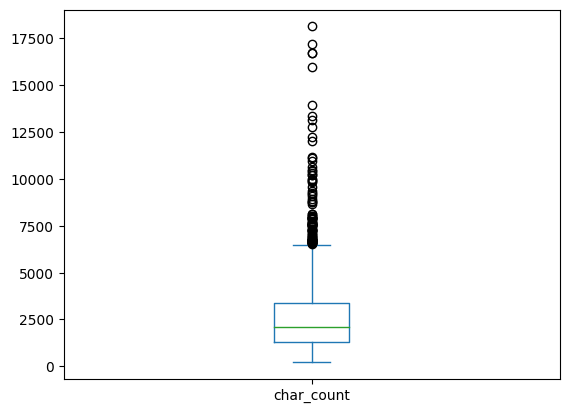

In [9]:
df1.plot(y='char_count', kind='box')

In [10]:
stats = df1['char_count'].describe()
stats

count     1788.000000
mean      2661.460291
std       2044.283050
min        211.000000
25%       1310.750000
50%       2109.500000
75%       3381.250000
max      18144.000000
Name: char_count, dtype: float64

In [11]:
average_chars_count_per_word = 5
average_word_count_per_1k_token = 750
mean_character_count = stats['mean']
mean_word_count = mean_character_count / average_chars_count_per_word
mean_token_count = mean_word_count * 1000 / average_word_count_per_1k_token

# Print assumptions and context size
print(f"# ASSUMPTIONS:\n- Mean character count: {mean_character_count}")
print(f"- Average chars count per word: {average_chars_count_per_word}")
print(f"- Average word count per 1k tokens: {average_word_count_per_1k_token}\n")
context_size_required = math.ceil(mean_token_count)
print(f"> The context size required is approximately {context_size_required} tokens.\n")

# Cost calculation
model_cost = {
    "instruct-gpt-ada":    0.0004,
    "gpt3.5-turbo-4k-ctx": 0.0015,
    "gpt4-8k-ctx":         0.03,
}

cost_data = []

for model, cost_per_1k_token in model_cost.items():
    for sample_count in [1, 1000, 10_000]:
        # Round up the token count to ensure no cost underestimation
        rounded_token_count = math.ceil(mean_token_count)
        # Calculate the cost
        estimated_cost = cost_per_1k_token * rounded_token_count / 1000 * sample_count
        # Add the data to the list
        cost_data.append([model, sample_count, estimated_cost])

# Convert list to DataFrame
cost_df = pd.DataFrame(cost_data, columns=['Model', 'Sample(s)', 'Cost (USD)'])

# Round the cost to 2 decimal places
cost_df['Cost (USD)'] = cost_df['Cost (USD)'].round(2)

print("* References prices: https://openai.com/pricing#language-models\n")

# Display DataFrame
print(cost_df)

# ASSUMPTIONS:
- Mean character count: 2661.4602908277407
- Average chars count per word: 5
- Average word count per 1k tokens: 750

> The context size required is approximately 710 tokens.

* References prices: https://openai.com/pricing#language-models

                 Model  Sample(s)  Cost (USD)
0     instruct-gpt-ada          1        0.00
1     instruct-gpt-ada       1000        0.28
2     instruct-gpt-ada      10000        2.84
3  gpt3.5-turbo-4k-ctx          1        0.00
4  gpt3.5-turbo-4k-ctx       1000        1.06
5  gpt3.5-turbo-4k-ctx      10000       10.65
6          gpt4-8k-ctx          1        0.02
7          gpt4-8k-ctx       1000       21.30
8          gpt4-8k-ctx      10000      213.00


`Conclusion`: Class imbalance is a problem that could be tackled with data synthesization.